# The simulation is only for one transducer.
This is an example of inversion for 1/Q.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os
from os import path
import shutil
from matplotlib.pyplot import MultipleLocator
import matplotlib.ticker
from functions_mc import read_sim_header, read_sim#, read_sec, read_trc
read_sec = 0
read_trc = 0
read_header = read_sim_header

def position(Number): 
    r = re.compile("([a-zA-Z]+)([0-9]+)")
    m = r.match(Number)
    num = int(m.group(2)) 
    with open('./models/Sensor_coordinates.txt') as f:
        lines = f.readlines()
    line = lines[num-119]
    line =line.replace("  "," ")
    line =line.replace("  "," ")
    line =line.replace("  "," ")
    y = int(line.split(' ')[5])
    x = int(line.split(' ')[4])
    return x,y

class mc_sim():
    def __init__(self,filename):
        """Read and analyze MC simulation.
        """
        # extract first part of filename without file extension
        self.sim_base_name = path.split(filename)[1][:-4]
        # path of the simulation folder
        self.sim_path = path.split(filename)[0]
        # read simulation header
        self.head = read_sim_header(filename)
        reading = {0:{'extension':'sim',
                      'read_func':read_sim},
                   1:{'extension':'sec',
                      'read_func':read_sec},
                   2:{'extension':'trc',
                      'read_func':read_trc}
                  }
        opt = self.head['outputtype']
        files = glob.glob(path.join(self.sim_path,
                                    self.sim_base_name+'*.%s' 
                                    % reading[opt]['extension']))
        self.data = {}
        for fname in files:
            # recording type encoded in filename between last underscore
            # and the file extension
            rec_type = fname.split('_')[-1].split('.')[0]
            data, axes = reading[opt]['read_func'](fname,self.head)
            if hasattr(self,'axes'):
                assert axes.keys() == self.axes.keys(), 'Axes of different recording types'\
                                          'must be identical'
                for key in axes.keys():
                    assert np.all(axes[key] == self.axes[key]), 'Axes of different recording types'\
                                          'must be identical'
            else:
                self.axes = axes
            self.data.update({rec_type:data})
            
def local_energy_density(x,y,z,mc,rec_type):
    lenth = 0
    ar = np.arange(-lenth,1+lenth,1)
    s_ar = mc.head['GridSpacing'][0] * mc.head['GridSpacing'][1] 
    x_ind = np.argmin(np.abs(mc.axes['x']-x))
    y_ind = np.argmin(np.abs(mc.axes['y']-y))
    z_ind = np.argmin(np.abs(mc.axes['z']-z))
#       time_ind=(mc.axes['t']*10).astype(int)
    x_ar = ar+ x_ind
    x_ar = [n for n in x_ar if n > 0 and n <len(mc.axes['x'])-1]
    y_ar = ar+ y_ind
    y_ar = [n for n in y_ar if n > 0 and n <len(mc.axes['y'])-1]
    data_ini=mc.data[rec_type][:,:,z_ind,:]
    data_sed = data_ini[x_ar,:,:]
    data_thi = data_sed[:,y_ar,:]
    #data = (np.mean(np.mean(data_thi,0),0)/s_ar)/mc.head['npart']
    data = np.sum(np.mean(np.mean(data_thi,0),0),0)/s_ar/mc.head['npart']/mc.head['emodulo']/10
    #data = np.mean(np.mean(np.mean(data_thi,0),0),0)/s_ar
    return data,x_ind,y_ind

import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

def get_axis_limits(ax, scale_x=.0, scale_y=.8):
    return ax.get_xlim()[1]*scale_x, ax.get_ylim()[1]*scale_y

# Check the model of 1/Q for curent iteraion 

The model of iteraion 0 exists.


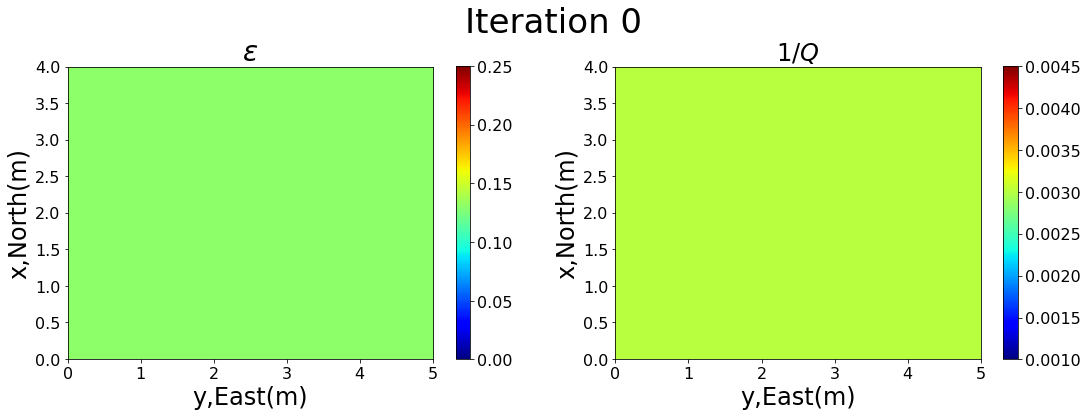

In [18]:
iteration = 0 #start form 0

########################################
plot_ = False
for i in np.arange(iteration,-1,-1):
    if not os.path.exists('./models/Qp_model_iteration_'+str(i)+'.bin'):
        print('There is no model for the iteraion %s, please go back to the iteration %s.'%(i,i-1))
    else:
        plot_ = True
        print('The model of iteraion %s exists.'%(i))
        break
if plot_ == True:   
    fig, axs = plt.subplots(1,2,figsize=(18,6))    
    fig.suptitle('Iteration %s'%iteration,fontsize= 34)
    Model_Q  = np.fromfile('./models/Qp_model_iteration_'+str(i)+'.bin')
    Model_eps  =  np.fromfile('./models/epsilon_model_iteration_0.bin')
    for i in np.arange(2):
        ax = axs[i]
        ax.set_ylabel('x,North(m)',fontsize= 24)
        ax.set_xlabel('y,East(m)',fontsize= 24)  
        ax.tick_params(axis='both', labelsize=16)

    im = axs[1].imshow(np.reshape(Model_Q,(100,125)), extent=[0,5,0,4],aspect=1., origin='lower',cmap='jet',vmax=0.0045, vmin=0.001)
    axs[1].set_title(r'$1/Q $',fontsize= 24)
    cbar=plt.colorbar(im,ax=axs[1],shrink=0.9)
    cbar.ax.tick_params(labelsize=16)

    im = axs[0].imshow(np.reshape(Model_eps,(100,125)), extent=[0,5,0,4],aspect=1., origin='lower',cmap='jet',vmax=0.25, vmin=0.0)
    axs[0].set_title(r'$\varepsilon $',fontsize= 28)
    cbar=plt.colorbar(im,ax=axs[0],shrink=0.9)
    cbar.ax.tick_params(labelsize=16)

# Create the folder for this iteration 

In [3]:
dir_iter = './simu_data/iteration_'+ str(iteration)
if not os.path.exists(dir_iter):
    os.makedirs(dir_iter)

# Show the setup of the transdusers

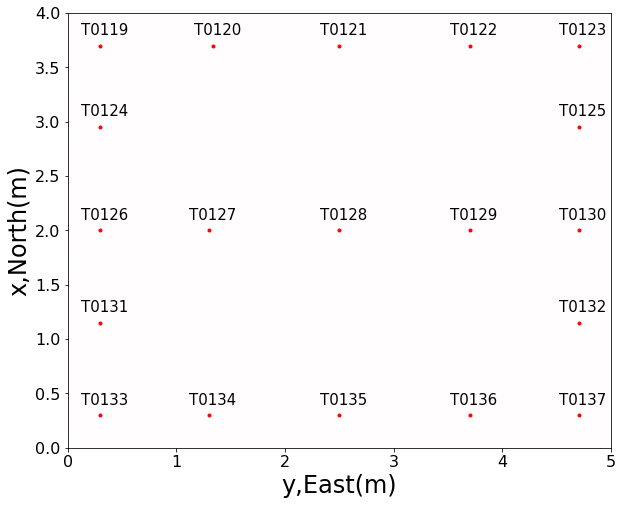

In [19]:
fig, axs = plt.subplots(1,1,figsize=(10, 8))
for i in np.arange(19):
    EMB = 'T0'+str(i+119) 
    plt.scatter(position(EMB)[1]/1000,position(EMB)[0]/1000,c = 'r',marker = '.')
    axs.annotate(EMB, (position(EMB)[1]/1000-0.18,position(EMB)[0]/1000+0.1),fontsize= 15)    
axs = plt.imshow(np.zeros((500,400)), extent=[0,5,0,4],aspect=1., origin='lower',cmap='seismic',vmax=0.1, vmin=-0.1)
plt.ylabel('x,North(m)',fontsize= 24)
plt.xlabel('y,East(m)',fontsize= 24)     
plt.tick_params(axis='both', labelsize=16)

# Chose one transduser for simulation 

In [28]:
transduser = 121 # from 119 to 137

###################################################
dir_tran = dir_iter+'/location_'+ str(transduser)
src = './simulation_code' # Source path 
dest = dir_tran # Destination path 
if not os.path.exists(dir_tran):
    shutil.copytree(src, dest) #copy simulation code

shutil.copy2('./models/Qp_model_iteration_'+str(iteration)+'.bin', dest)
shutil.copy2('./models/epsilon_model_iteration_0.bin', dest)
shutil.copy2('./models/Qs_model.bin', dest)
    
with open('./models/location.txt') as f:
    lines = f.readlines()
    x_sor = lines[transduser-119].split(' ')[0]
    y_sor = lines[transduser-119].split(' ')[1].split('\n')[0]

# Chose the parameters for simualtion

In [29]:
paticle_num = 10000 #number of particles


###################################################
para_file = open(dir_tran+'/parfile.txt', "r")
list_of_lines = para_file.readlines()
######
for i in np.arange(len(list_of_lines)):
    if 'Simulation Tag:' in list_of_lines[i]:
        list_of_lines[i] = 'Simulation Tag: Acoustic_forward_with_boundary_iter_%s_location_%s\n'%(iteration,transduser)
    if 'Source position (x, y, z) in m from grid origin:' in list_of_lines[i]:
        list_of_lines[i] = 'Source position (x, y, z) in m from grid origin: %s %s 0.50000\n'%(x_sor,y_sor)
    if 'Number of Particles:' in list_of_lines[i]:
        list_of_lines[i] = 'Number of Particles: %s\n'%(paticle_num)
    if 'File for Intrinsic Attenuation 1/Q_p:' in list_of_lines[i]:
        list_of_lines[i] = 'File for Intrinsic Attenuation 1/Q_p: Qp_model_iteration_%s.bin\n'%(iteration)
######
para_file = open(dir_tran+'/parfile.txt', "w")
para_file.writelines(list_of_lines)
para_file.close()

# run the simulation coda

In [30]:
! module load intel/intel-2019u5 #load c program compiler
os.chdir(dir_tran) # go into the simulation folder
! make #compile
! ./ecount parfile.txt #run the simulation program
os.chdir("../../..") #back to the main directory

gcc  -c ecount.c
gcc  -c eutility.c
gcc  -c mk_scat_pattern.c
gcc  -c incidence.c
gcc  -c mk_source_pattern.c
gcc  -c scatter_2D.c
gcc  -c surface.c
gcc  -c layer.c
gcc  ecount.o eutility.o incidence.o mk_scat_pattern.o mk_source_pattern.o scatter_2D.o surface.o  layer.o -lm -o ecount

***************************
eutility.c:23 No error before:CALL OF ReadParFile
***************************

***************************
eutility.c:94 No error before:MARK2
***************************

***************************
Name of parameter file: parfile.txt
***************************


***************************
eutility.c:110 No error before:CALL OF ReadModelFile
***************************

***************************
eutility.c:186 No error before:MARK3
***************************

mk_scat_pattern.c:354 Error opening file tables/expo_1.7341e+00_1.4592e+02_1.1000e-02_1.0000e+00_8.0000e-01_1.00e+05_scat.dat
Recalculating propability tables for scattering pattern.
***************************
euti

# read simulation result

Text(4.40118, 0.4338506904244423, '(g) Envelopes')

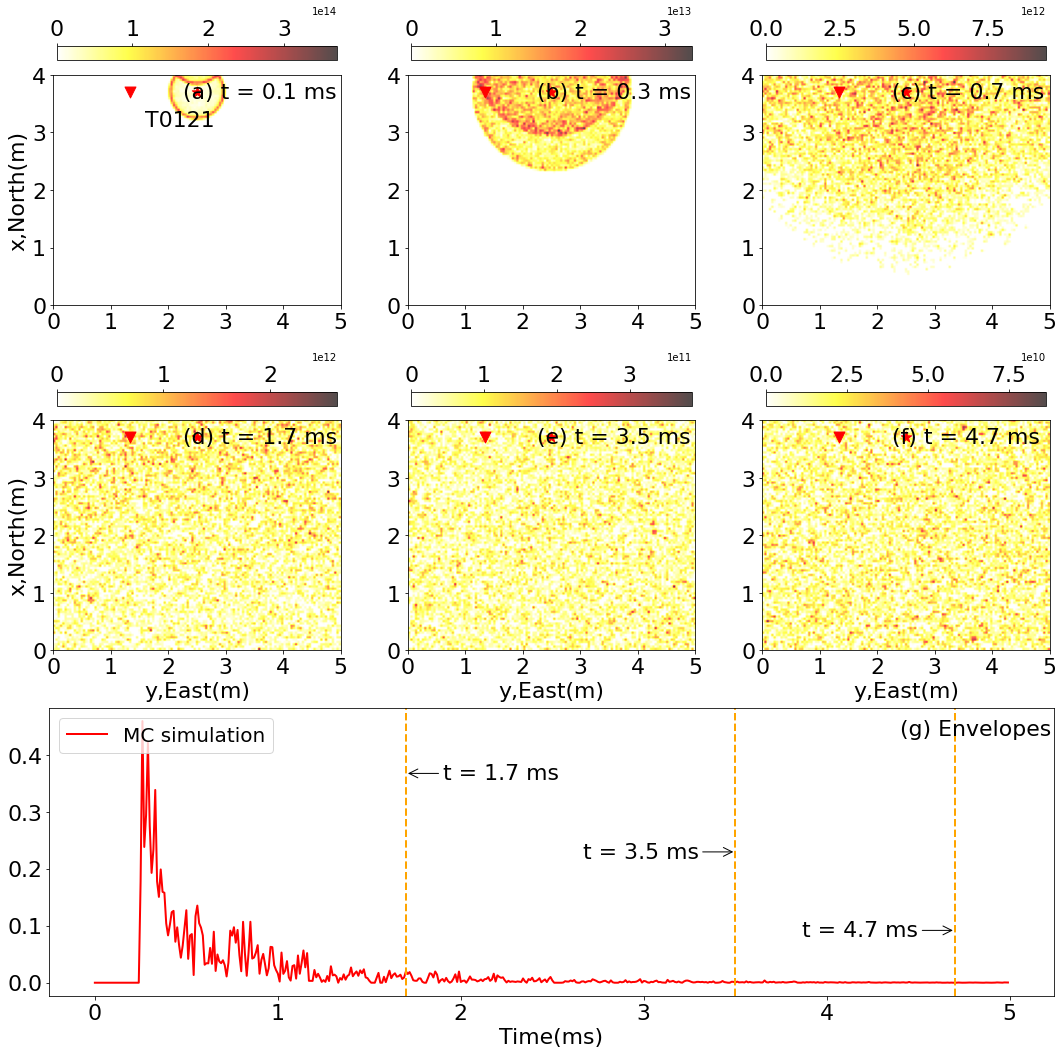

In [31]:
Receiver = 120


######################simulation#######################
sim_T = mc_sim(dir_tran+ '/sims/Acoustic_forward_with_boundary_*.hed')       
x1= position('T0'+str(int(Receiver)))[0]/1000
y1= position('T0'+str(int(Receiver)))[1]/1000
###################
y_simu = local_energy_density(x1,y1,0,sim_T,'P')[0]
t_syn=sim_T.axes['t']
#######################################################
t_sim = [0.1, 0.3, 0.7 ,1.7,3.5,4.7]
num_t = len(t_sim)
wavefield_t = []
for i in np.arange(num_t):
    wavefield_t.append(np.sum(sim_T.data['P'][:,:,0,:,int(t_sim[i]/0.01)],2))

transducer_S = 'T0'+str(transduser) 
transducer_R = 'T0'+str(Receiver) 
Source_x = position(transducer_S)[0]/1000
Source_y = position(transducer_S)[1]/1000
Receiver_x = position(transducer_R)[0]/1000
Receiver_y = position(transducer_R)[1]/1000
fig = plt.figure(figsize=(18, 18))
fontsize_ =22
labelsize = 22
#fig.suptitle('Source: T0%s, Station: T0%s'%(Source,Receiver),fontsize=fontsize_)

# set up subplot grid
gridspec.GridSpec(3,3)
axs = []
abc = ['(a)','(b)','(c)','(d)','(e)','(f)']
for i in np.arange(6):
    axs.append(plt.subplot2grid((3,3), (int(i/3), int(i%3)),colspan=1,rowspan=1))
axs.append(plt.subplot2grid((3,3), (2, 0),colspan=3,rowspan=1))

s_ar = sim_T.head['GridSpacing'][0] * sim_T.head['GridSpacing'][1] 

for i in np.arange(6):
    ax = axs[i]
    vmax_ = np.max(wavefield_t[i])
    vmin_ = np.min(wavefield_t[i])
    im = ax.imshow(wavefield_t[i], extent=[0,5,0,4],aspect=1., origin='lower',cmap='hot_r', alpha = 0.7)
    ax.scatter(Source_y,Source_x,c = 'r',marker = '*',s =120)
    ax.scatter(Receiver_y,Receiver_x,c = 'r',marker = 'v',s =120)
    cbar=plt.colorbar(im,ax=ax,shrink=0.95,location='top')
    cbar.ax.tick_params(labelsize=labelsize)
    ax.tick_params(axis='both', labelsize=labelsize)
    ax.annotate(abc[i]+' t = %s ms'%(t_sim[i]), xy=get_axis_limits(ax,scale_x=.45, scale_y=.9),fontsize=fontsize_)
    y_major_locator=MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    ax.xaxis.set_major_locator(y_major_locator)
    if i == 0:
        ax.annotate(transducer_S, (Source_y-0.9,Source_x-0.6),fontsize= fontsize_)
        ax.annotate(transducer_R, (Receiver_y-0.7,Receiver_x+0.4),fontsize= fontsize_)
    if int(i/3)!=0:
        ax.set_xlabel('y,East(m)',fontsize= fontsize_)
    else:
        #ax.xaxis.set_ticks_position('top')
        o=0
    
    if int(i%3)!=0:
        o=0
        #ax.yaxis.set_visible(False)
    else:
        ax.set_ylabel('x,North(m)',fontsize= fontsize_) 
        

ax = axs[6]
ax.tick_params(axis='both', labelsize=labelsize)

ax.plot(t_syn,y_simu,c ='r',linewidth = 2,label = 'MC simulation')
####
ax.axvline(x=1.7,color='orange', linestyle='--',linewidth = 2)
ax.axvline(x=3.5,color='orange', linestyle='--',linewidth = 2)
ax.axvline(x=4.7,color='orange', linestyle='--',linewidth = 2)
#
loca_vert = max(y_simu)
ax.annotate('t = 1.7 ms',xy=(1.7,0.8*loca_vert),  xycoords='data',xytext=(1.9, 0.8*loca_vert), textcoords='data',size=fontsize_, va="center", ha="left",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0"),)
ax.annotate('t = 3.5 ms',xy=(3.5,0.5*loca_vert),  xycoords='data',xytext=(3.3, 0.5*loca_vert), textcoords='data',size=fontsize_, va="center", ha="right",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0"),)
ax.annotate('t = 4.7 ms',xy=(4.7,0.2*loca_vert),  xycoords='data',xytext=(4.5, 0.2*loca_vert), textcoords='data',size=fontsize_, va="center", ha="right",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0"),)
#####
ax.legend(prop={'size': fontsize_-2},loc = 2)
ax.set_xlabel('Time(ms)',fontsize=fontsize_)
ax.annotate('(g) Envelopes', xy=get_axis_limits(ax,scale_x=.84, scale_y=.9),fontsize=fontsize_)
    